In [55]:
!nvidia-smi

Wed Sep  2 03:15:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    34W /  70W |   8521MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [56]:
!pip install bert-for-tf2 >> /dev/null
!pip install sentencepiece >> /dev/null

In [57]:
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import copy 

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from tensorflow import keras

from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import doc2vec

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

import spacy
nlp = spacy.load('en_core_web_sm')

# from nltk.util import ngrams
# from collections import defaultdict
# from collections import Counter
plt.style.use('ggplot')
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# stopWordList=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub


from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

from sklearn import preprocessing

import bert 
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

In [58]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
rcParams['figure.figsize'] = 12,8

# Load the data

In [59]:
df_train= pd.read_csv('train5.csv')
df_test=pd.read_csv('test.csv')

# Check the dataframe

In [60]:
df_train

,category,question
0,DESC,manner How did serfdom develop in and then lea...
1,ENTY,cremat What films featured the character Popey...
2,DESC,manner How can I find a list of celebrities ' ...
3,ENTY,animal What fowl grabs the spotlight after the...
4,ABBR,exp What is the full form of .com ?
...,...,...
5447,ENTY,other What 's the shape of a camel 's spine ?
5448,ENTY,currency What type of currency is used in China ?
5449,NUM,temp What is the temperature today ?
5450,NUM,temp What is the temperature for cooking ?


# Check data distribution per category

Text(0.5, 1.0, 'Number of examples per category')

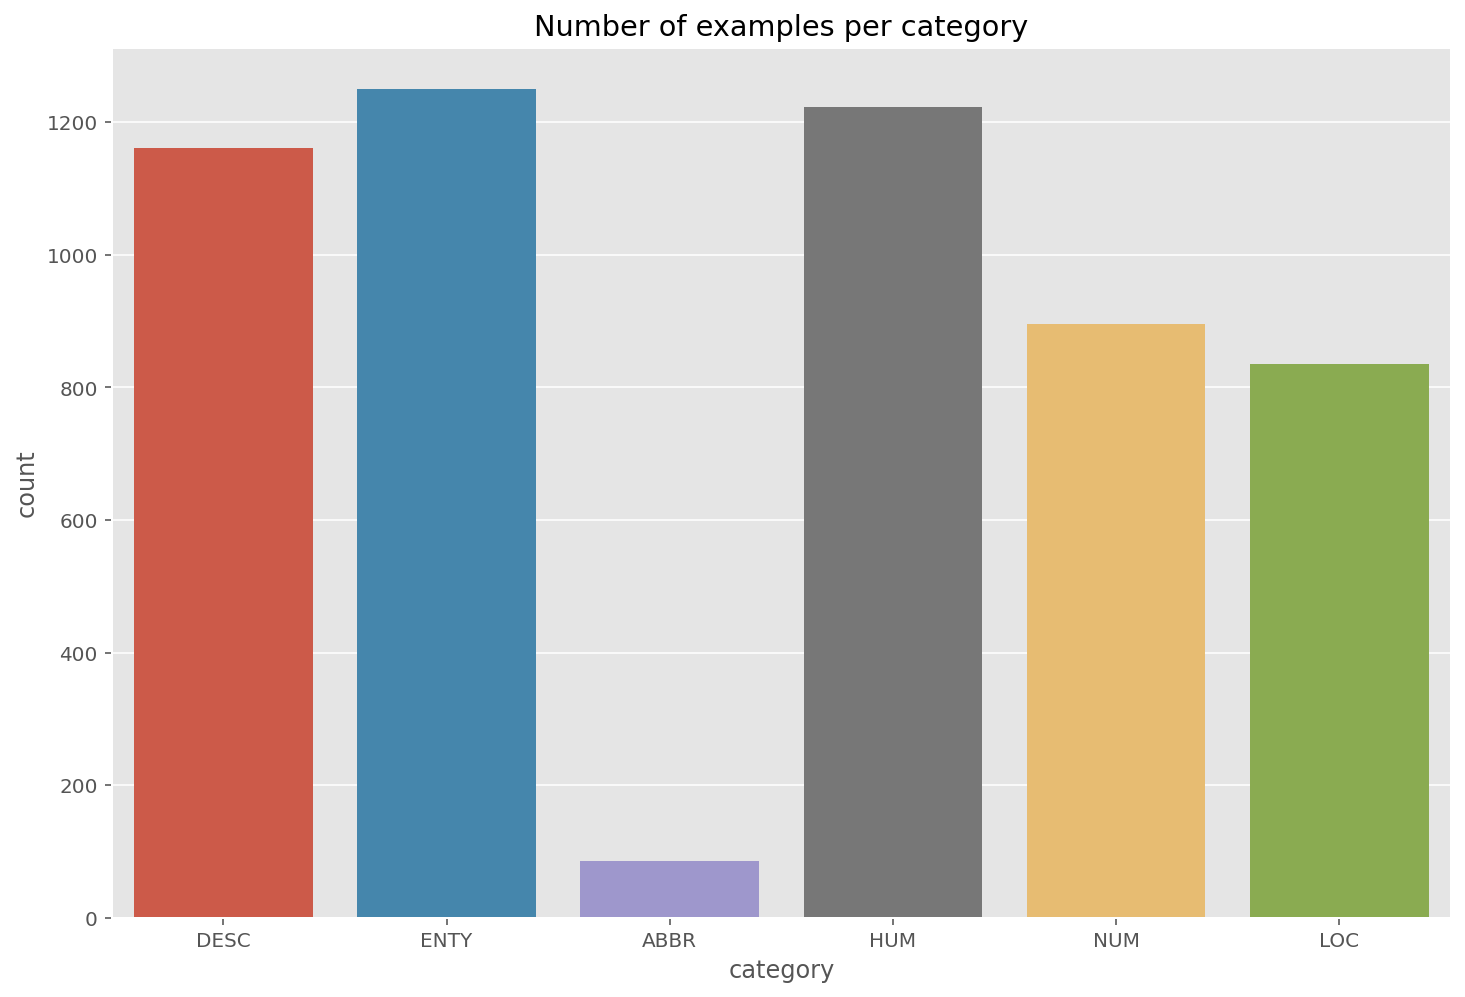

In [61]:
chart = sns.countplot(df_train.category)
plt.title("Number of examples per category")

# Check the distribution of the questions' length

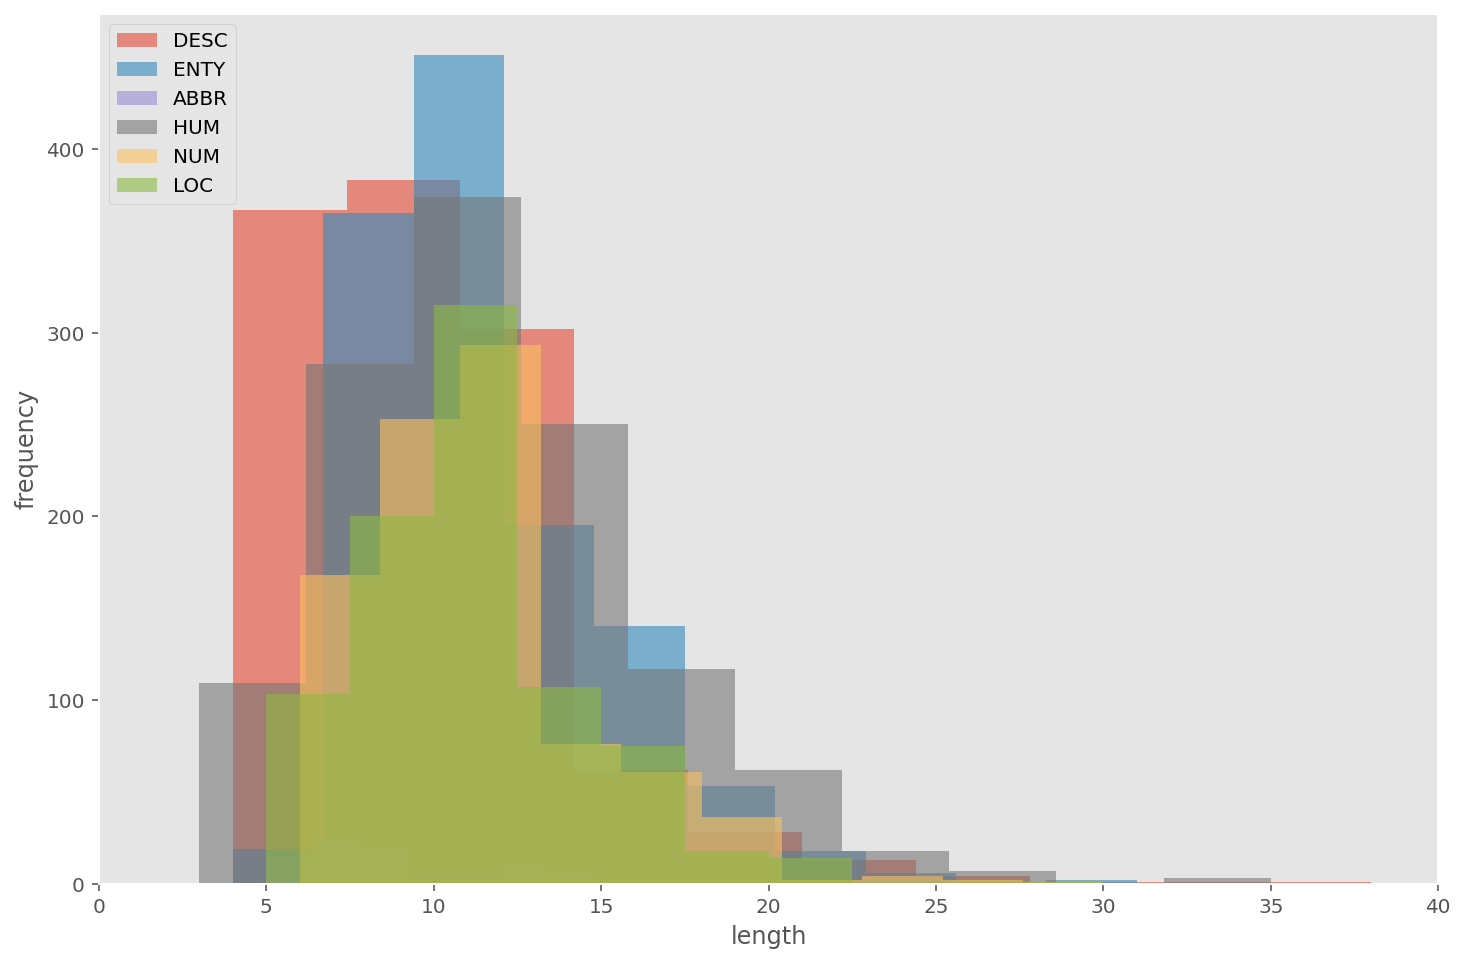

In [62]:
df_train['length'] = df_train['question'].str.split().apply(len)
bins = 10
plt.hist(df_train[df_train['category'] == 'DESC']['length'], alpha = 0.6, bins=bins, label='DESC')
plt.hist(df_train[df_train['category'] == 'ENTY']['length'], alpha = 0.6, bins=bins, label='ENTY')
plt.hist(df_train[df_train['category'] == 'ABBR']['length'], alpha = 0.6, bins=bins, label='ABBR')
plt.hist(df_train[df_train['category'] == 'HUM']['length'], alpha = 0.6, bins=bins, label='HUM')
plt.hist(df_train[df_train['category'] == 'NUM']['length'], alpha = 0.6, bins=bins, label='NUM')
plt.hist(df_train[df_train['category'] == 'LOC']['length'], alpha = 0.6, bins=bins, label='LOC')
plt.xlabel('length')
plt.ylabel('frequency')
plt.legend(loc='upper left')
plt.xlim(0,40)
plt.grid()
plt.show()

## From the distribution it seems like the highest length of questions of any category is 35. 

# Check for null values in the dataframe

In [63]:
#check null values
df_train.isna().sum().sort_values(ascending=False)

length      0
question    0
category    0
dtype: int64

There is no null values in the samples.

# Train-test split

In [64]:
# Encoding labels
encoder = preprocessing.LabelEncoder()
encoder.fit(df_train['category'])
train_label = encoder.transform(df_train['category'])
test_label = encoder.transform(df_test['category'])
df_train['category_en'] = train_label
df_test['category_en'] = test_label

# train-val split
text = df_train["question"].tolist()
labels = train_label
X_train, X_val, y_train, y_val = train_test_split(text, labels, test_size=0.2, random_state=RANDOM_SEED)

#test data
X_test = df_test['question']
y_test = df_test['category']

# Check the data
df_train.head(20)

,category,question,length,category_en
0,DESC,manner How did serfdom develop in and then lea...,11,1
1,ENTY,cremat What films featured the character Popey...,9,2
2,DESC,manner How can I find a list of celebrities ' ...,13,1
3,ENTY,animal What fowl grabs the spotlight after the...,14,2
4,ABBR,exp What is the full form of .com ?,9,0
5,HUM,ind What contemptible scoundrel stole the cork...,11,3
6,HUM,gr What team did baseball 's St. Louis Browns ...,11,3
7,HUM,title What is the oldest profession ?,7,3
8,DESC,def What are liver enzymes ?,6,1
9,HUM,ind Name the scar-faced bounty hunter of The O...,11,3


# Helper function for performance and confusion matrix analysis

In [65]:
# Classificaiton metrics - precision, recall, f1, and accuracy
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

# Ploting loss and accuracy graphs
def plot_graphs(f, history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title("Training "+ string+ " VS "+ "Validation "+string)
    plt.show()

# Tf-Idf + SVM Model

In [66]:
# Define model pipeline
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l1',alpha=1e-3, random_state=RANDOM_SEED, max_iter=5, tol=None)),
               ])

sgd.fit(X_train, y_train)

y_pred_svm = sgd.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(df_test.category_en, y_pred_svm)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f \n" % (accuracy, precision, recall, f1))

accuracy = 0.934 
precision = 0.940 
recall = 0.934 
f1 = 0.935 



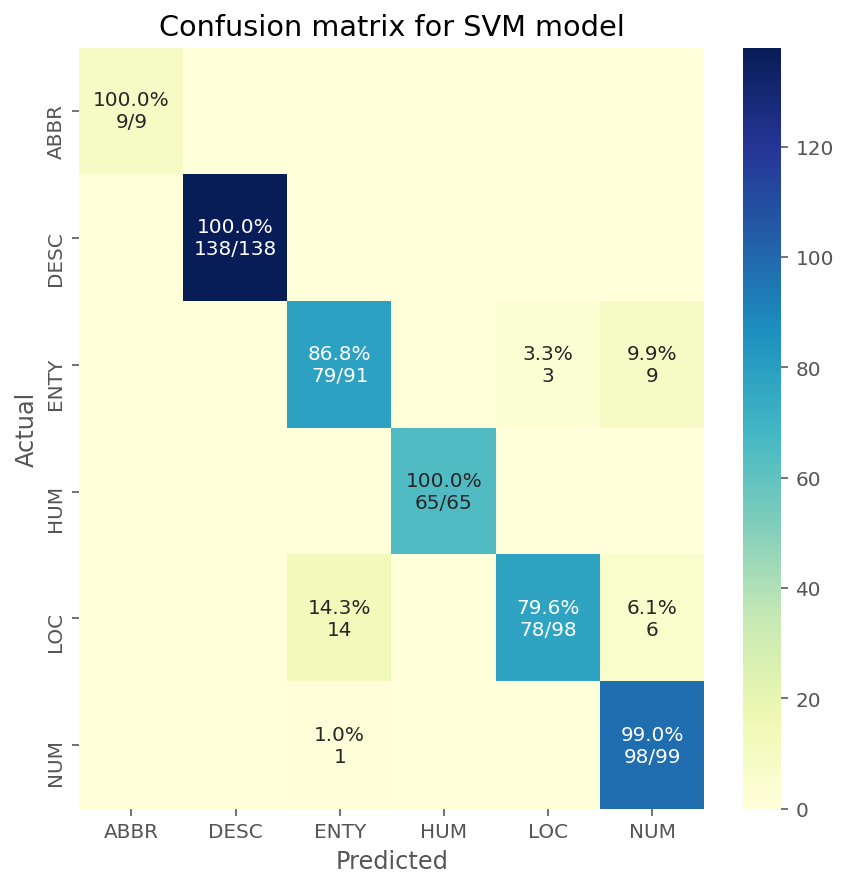

In [67]:
# decode the label encoded results
test_pred_decode = encoder.inverse_transform(y_pred_svm)
# Showing Confusion Matrix for SVM model
plot_cm(test_pred_decode, df_test.category, 'Confusion matrix for SVM model', figsize=(7,7))

In [68]:
# Save results
data = {'model': 'Tf-Idf + SVM', 'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}
df_performance = pd.DataFrame(data, index=[0])

# Doc2Vec + Logistic Regression

In [69]:
# helper moethod to preprocess text according to the Doc2Vec model
def create_corpus_d2v(df):
    """
    The format will be ["word tokens", "label"]
    """
    #Tag train set
  
    labeled = []
    for i, v in enumerate(tqdm(df['question'])):
        label = df['category_en'][i]
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

X_train_lr = create_corpus_d2v(df_train)
X_test_lr = create_corpus_d2v(df_test)

100%|██████████| 500/500 [00:00<00:00, 28335.68it/s]


In [70]:
X_train_lr[:5]

[TaggedDocument(words=['manner', 'How', 'did', 'serfdom', 'develop', 'in', 'and', 'then', 'leave', 'Russia', '?'], tags=[1]),
 TaggedDocument(words=['cremat', 'What', 'films', 'featured', 'the', 'character', 'Popeye', 'Doyle', '?'], tags=[2]),
 TaggedDocument(words=['manner', 'How', 'can', 'I', 'find', 'a', 'list', 'of', 'celebrities', "'", 'real', 'names', '?'], tags=[1]),
 TaggedDocument(words=['animal', 'What', 'fowl', 'grabs', 'the', 'spotlight', 'after', 'the', 'Chinese', 'Year', 'of', 'the', 'Monkey', '?'], tags=[2]),
 TaggedDocument(words=['exp', 'What', 'is', 'the', 'full', 'form', 'of', '.com', '?'], tags=[0])]

In [71]:
# Define doc2vec 
model_d2v = Doc2Vec( 
    dm=0, # 0: PV-DBOW
    vector_size=100, 
    negative=5, 
    min_count=2, 
    alpha=0.065, 
    min_alpha=0.065)

# Build vocabulary with only training samples
model_d2v.build_vocab([x for x in tqdm(X_train_lr)])

100%|██████████| 5452/5452 [00:00<00:00, 1358563.77it/s]


In [72]:
train_documents  = utils.shuffle(X_train_lr)
test_documents = X_test_lr

# train the d2v model
model_d2v.train(train_documents,total_examples=len(train_documents), epochs=300)

# Save model for future use
model_d2v.save('./d2vModel.d2v')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [73]:
def vector_for_d2v(model, input_docs):
    sents = input_docs
    targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=30)) for doc in sents])
    return targets, feature_vectors

y_train_d2v, X_train_d2v = vector_for_d2v(model_d2v, train_documents)
y_test_d2v, X_test_d2v = vector_for_d2v(model_d2v, test_documents)

In [74]:
# Check the d2v embedding 
X_train_d2v[:5]

(array([-4.42601085e-01, -1.82910100e-01,  4.39485669e-01, -1.55898958e-01,
         3.13192487e-01,  8.27130280e-04, -3.80994529e-01,  4.97793943e-01,
        -2.65299499e-01, -8.12672377e-02,  5.50777018e-01, -1.83051929e-01,
         7.16212764e-02, -2.48471767e-01, -1.37321204e-02, -3.36287171e-01,
        -3.33612472e-01, -5.71467459e-01, -1.25009686e-01,  4.93738949e-01,
        -2.11705193e-01, -3.50029200e-01,  3.10762554e-01,  3.06048244e-01,
        -8.03892761e-02, -1.79324225e-01,  4.94103640e-01,  7.73762167e-03,
         2.40725502e-02,  1.02126665e-01,  8.37220177e-02,  5.30953333e-02,
        -1.60119772e-01,  1.46774828e-01,  6.59624159e-01, -5.69067538e-01,
         3.62092227e-01, -4.15172517e-01,  4.60868746e-01,  5.00541508e-01,
        -4.13107783e-01, -2.20535249e-01, -1.10399283e-01,  1.89791173e-01,
         5.36804020e-01,  3.59226108e-01,  4.20228392e-01, -2.12184742e-01,
         3.01109366e-02, -1.73464149e-01, -1.29453912e-01,  1.16747662e-01,
         3.4

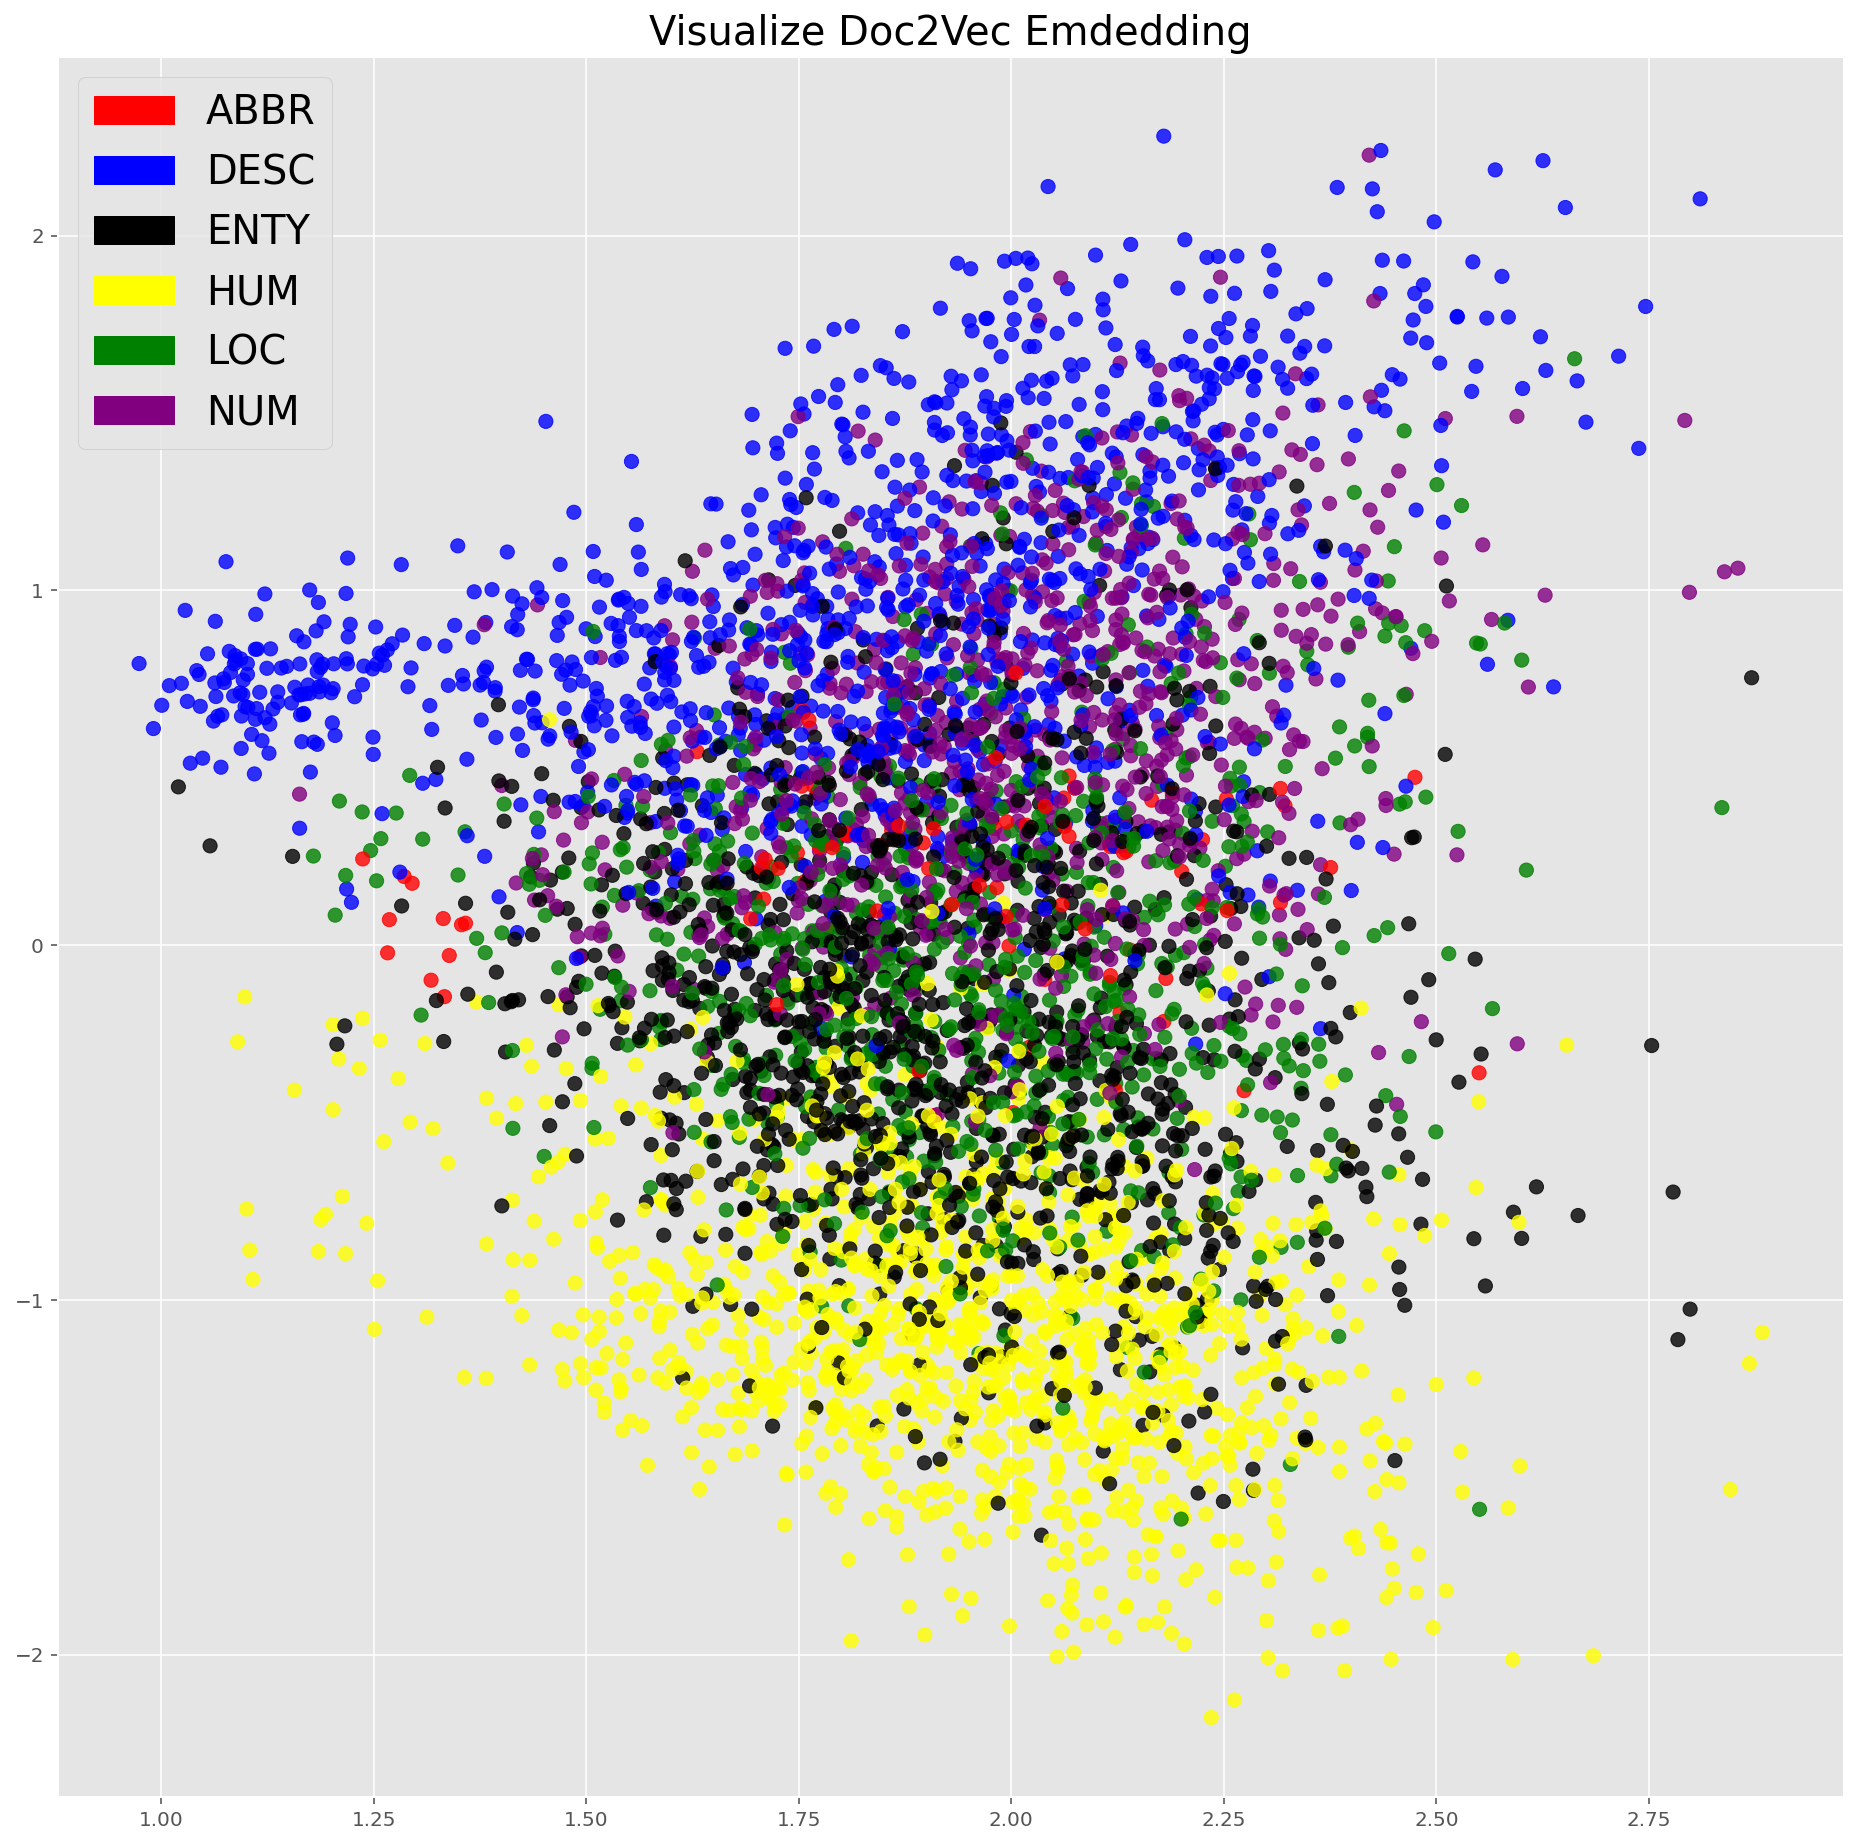

In [75]:
# Ref: https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb
# Using LSA - Latent Semantic Analysis to visualize the vectors in 2d space
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
  lsa = TruncatedSVD(n_components=2) # Singular Value Decomposition
  lsa.fit(test_data)
  lsa_scores = lsa.transform(test_data)
  color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
  color_column = [color_mapper[label] for label in test_labels]
  colors = ['red','blue','black', 'yellow', 'green', 'purple']
  if plot:
    plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=50, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
    red_patch = mpatches.Patch(color='red', label='ABBR')
    blue_patch = mpatches.Patch(color='blue', label='DESC')
    black_patch = mpatches.Patch(color='black', label='ENTY')
    yellow_patch = mpatches.Patch(color='yellow', label='HUM')
    green_patch = mpatches.Patch(color='green', label='LOC')
    purple_patch = mpatches.Patch(color='purple', label='NUM')
    plt.title('Visualize Doc2Vec Emdedding', fontsize=20)
    plt.legend(handles=[red_patch, blue_patch, black_patch, yellow_patch, green_patch, purple_patch], prop={'size': 20})

fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_d2v, y_train_d2v)
plt.show()

### The embeddings look quite separated in 2D space. Let's see if this leads to better performance.

In [76]:
# Define logistic regression model
logreg = LogisticRegression(C=5, multi_class='multinomial', solver='saga',max_iter=1000)
logreg.fit(X_train_d2v, y_train_d2v)
y_pred_lr = logreg.predict(X_test_d2v)

In [77]:
accuracy, precision, recall, f1 = get_metrics(df_test.category_en, y_pred_lr)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f \n" % (accuracy, precision, recall, f1))

accuracy = 0.942 
precision = 0.943 
recall = 0.942 
f1 = 0.942 



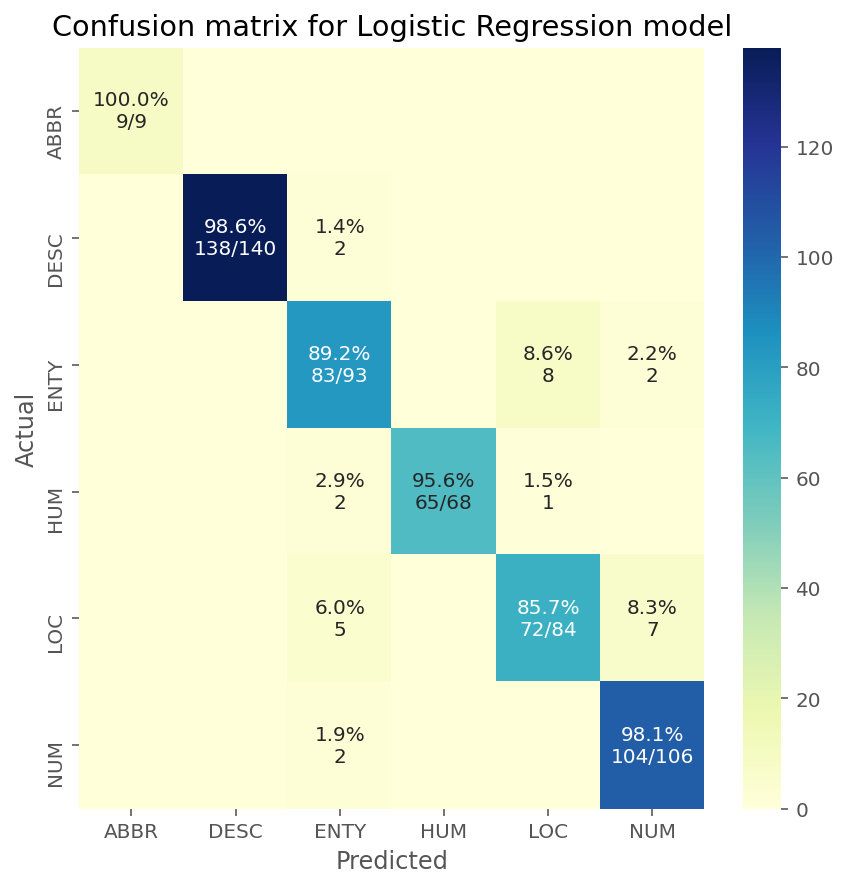

In [78]:
# decode the label encoded results
test_pred_decode = encoder.inverse_transform(y_pred_lr)
# Showing Confusion Matrix for LR model
plot_cm(test_pred_decode, df_test.category, 'Confusion matrix for Logistic Regression model', figsize=(7,7))

In [79]:
# Save results
data = {'model': 'Doc2Vec + Logistic Regression', 'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}
df_performance = df_performance.append(data, ignore_index=True)

# GloVe + LSTM Model

In [80]:
def create_corpus_new(df):
    corpus=[]
    for q in tqdm(df['question']):
        sentence = nlp(q)
        words = [i.text for i in sentence]
        corpus.append(words)
    return corpus   
corpus_train=create_corpus_new(df_train)
corpus_test = create_corpus_new(df_test)

100%|██████████| 500/500 [00:03<00:00, 130.88it/s]


In [81]:
# read the glove embedding and create a dict
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [82]:
# we have seen from the EDA that the max length available in the tweets is 35
MAX_LEN = 35
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus_train)
sequences_train=tokenizer_obj.texts_to_sequences(corpus_train)
sequences_test =tokenizer_obj.texts_to_sequences(corpus_test)

question_pad_train=pad_sequences(sequences_train,maxlen=MAX_LEN,truncating='post',padding='post')
question_pad_test=pad_sequences(sequences_test,maxlen=MAX_LEN,truncating='post',padding='post')

In [83]:
word_index=tokenizer_obj.word_index
num_words=len(word_index)+1

# defining the embedding matrix
embedding_matrix=np.zeros((num_words,100))
for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec


100%|██████████| 8489/8489 [00:00<00:00, 449336.78it/s]


In [84]:
# Check the embedding after processing
embedding_matrix[-5:]

array([[ 3.60199988e-01, -4.96619999e-01,  4.63819988e-02,
        -4.63190004e-02,  5.96149981e-01,  4.93620008e-01,
        -3.34820002e-01,  4.75019991e-01, -3.59429985e-01,
         1.77709997e-01, -1.46300003e-01, -6.40160024e-01,
        -4.79169995e-01, -1.83479995e-01, -2.59479992e-02,
        -8.84450018e-01,  7.18320012e-01,  5.06630003e-01,
         4.10589993e-01,  6.18219972e-01,  4.27789986e-01,
         4.93600011e-01,  8.82650018e-01,  5.02740026e-01,
        -7.00550020e-01,  2.25009993e-02, -5.82849979e-03,
        -1.38530004e+00,  8.84199977e-01, -4.09649998e-01,
        -3.65249991e-01,  2.24680007e-01,  3.70229989e-01,
         1.40540004e+00,  1.60080001e-01, -6.93740010e-01,
        -5.55669982e-03,  2.88980007e-02,  5.02269983e-01,
        -1.30290002e-01, -1.45640001e-01, -1.06429994e+00,
         5.67690015e-01, -4.42220002e-01,  3.79229993e-01,
         9.33500007e-02,  6.62790000e-01, -1.28959998e-01,
        -3.74850005e-01,  2.61229992e-01, -5.90960026e-0

In [85]:
#train-val split
X_train, X_val, y_train, y_val = train_test_split(question_pad_train, df_train['category_en'].values, test_size=0.2, random_state=1)

print('Shape of train',X_train.shape)
print("Shape of Validation ",X_val.shape)

Shape of train (4361, 35)
Shape of Validation  (1091, 35)


In [86]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))


model.compile(Adam(lr=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 100)           849000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 35, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 930,006
Trainable params: 81,006
Non-trainable params: 849,000
_________________________________________________________________


In [87]:
history_lstm = model.fit(X_train,y_train,batch_size=32,epochs=10,validation_data=(X_val,y_val),verbose=1)

Epoch 1/10
137/137 [==============================] - 19s 140ms/step - loss: 1.3790 - accuracy: 0.3914 - val_loss: 0.8532 - val_accuracy: 0.5811
Epoch 2/10
137/137 [==============================] - 19s 140ms/step - loss: 0.4578 - accuracy: 0.8471 - val_loss: 0.1448 - val_accuracy: 0.9542
Epoch 3/10
137/137 [==============================] - 19s 137ms/step - loss: 0.1792 - accuracy: 0.9450 - val_loss: 0.0911 - val_accuracy: 0.9679
Epoch 4/10
137/137 [==============================] - 19s 136ms/step - loss: 0.1349 - accuracy: 0.9548 - val_loss: 0.1062 - val_accuracy: 0.9661
Epoch 5/10
137/137 [==============================] - 19s 135ms/step - loss: 0.1017 - accuracy: 0.9665 - val_loss: 0.0673 - val_accuracy: 0.9725
Epoch 6/10
137/137 [==============================] - 19s 139ms/step - loss: 0.0920 - accuracy: 0.9672 - val_loss: 0.0530 - val_accuracy: 0.9798
Epoch 7/10
137/137 [==============================] - 18s 135ms/step - loss: 0.0775 - accuracy: 0.9741 - val_loss: 0.0537 - val_ac

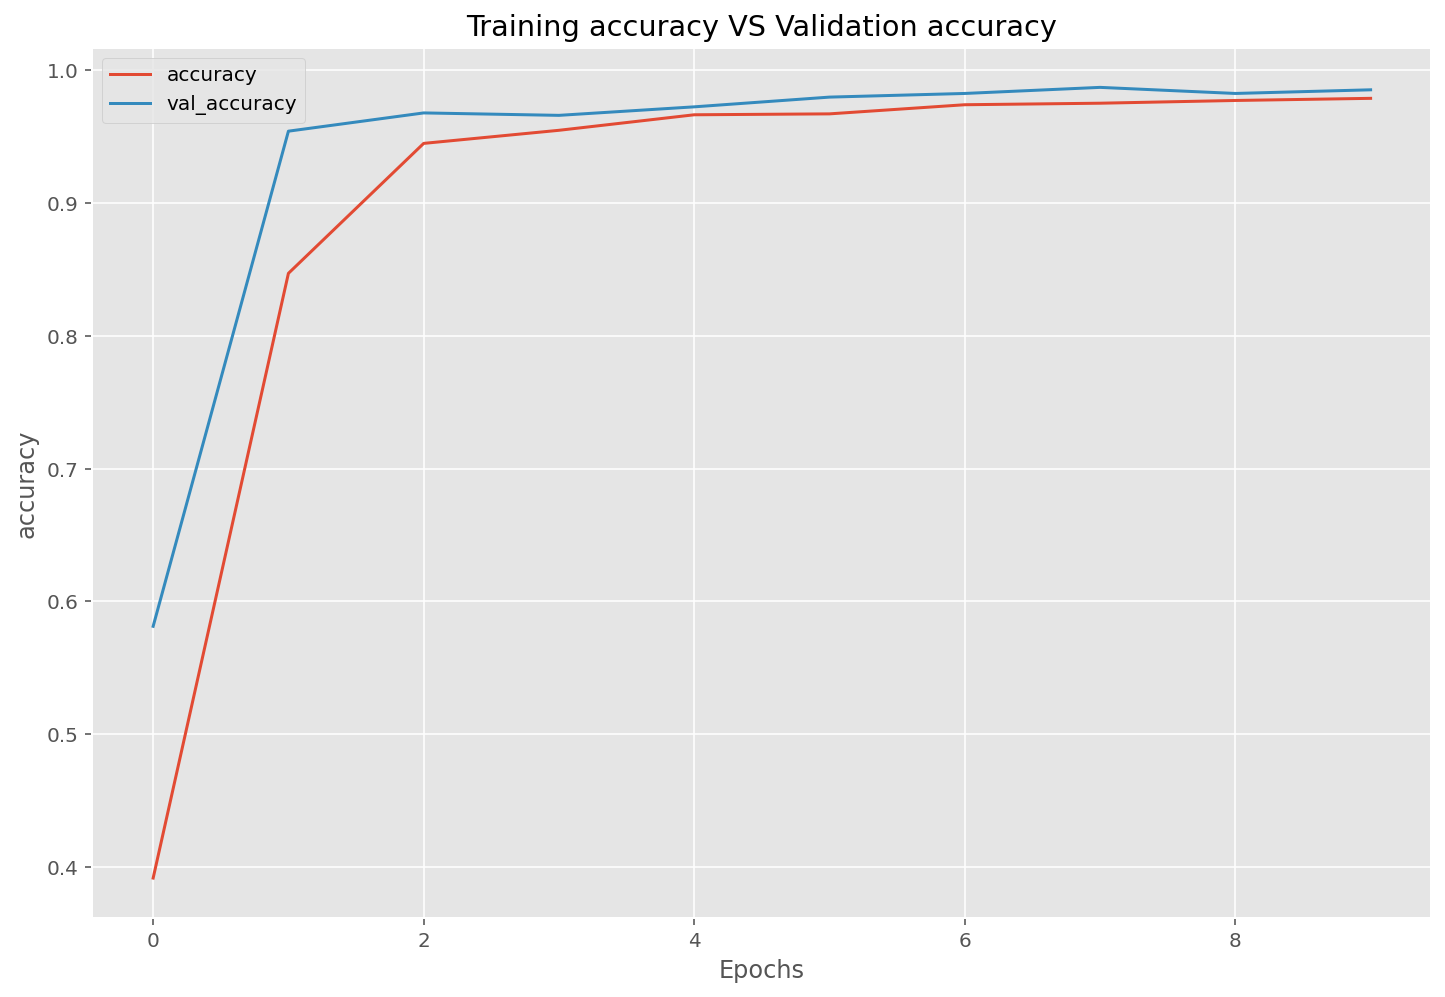

In [88]:
f1 = plt.figure()
plot_graphs(f1,history_lstm, "accuracy")

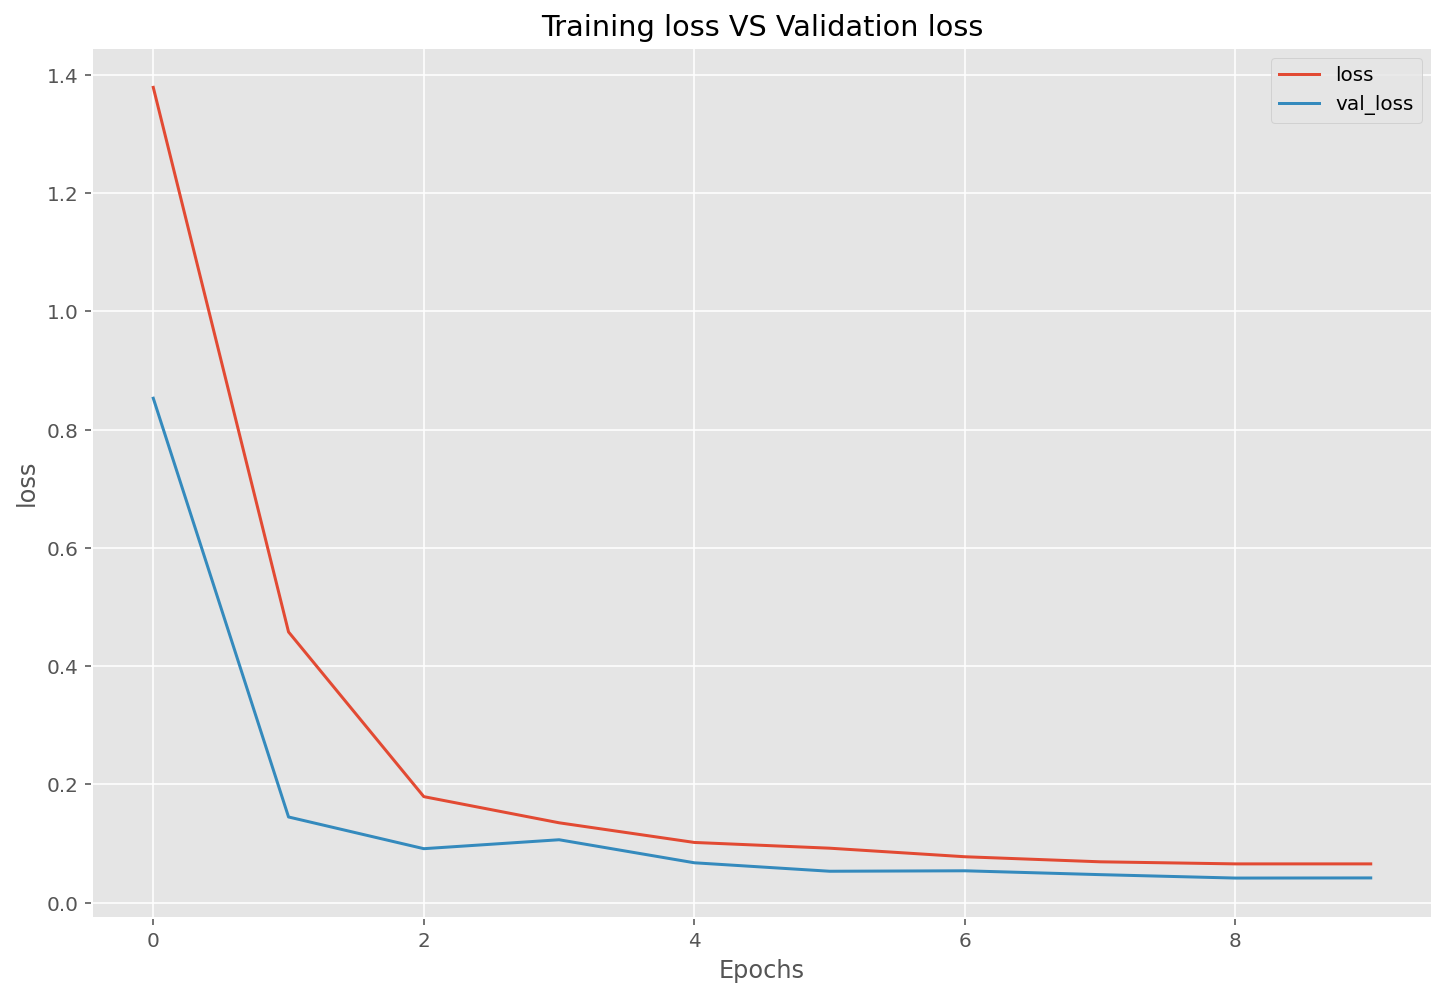

In [89]:
f2 = plt.figure()
plot_graphs(f2,history_lstm, "loss")

In [90]:
y_pred_lstm = model.predict(question_pad_test).argmax(axis=-1)
accuracy, precision, recall, f1 = get_metrics(df_test.category_en, y_pred_lstm)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f \n" % (accuracy, precision, recall, f1))

accuracy = 0.980 
precision = 0.980 
recall = 0.980 
f1 = 0.980 



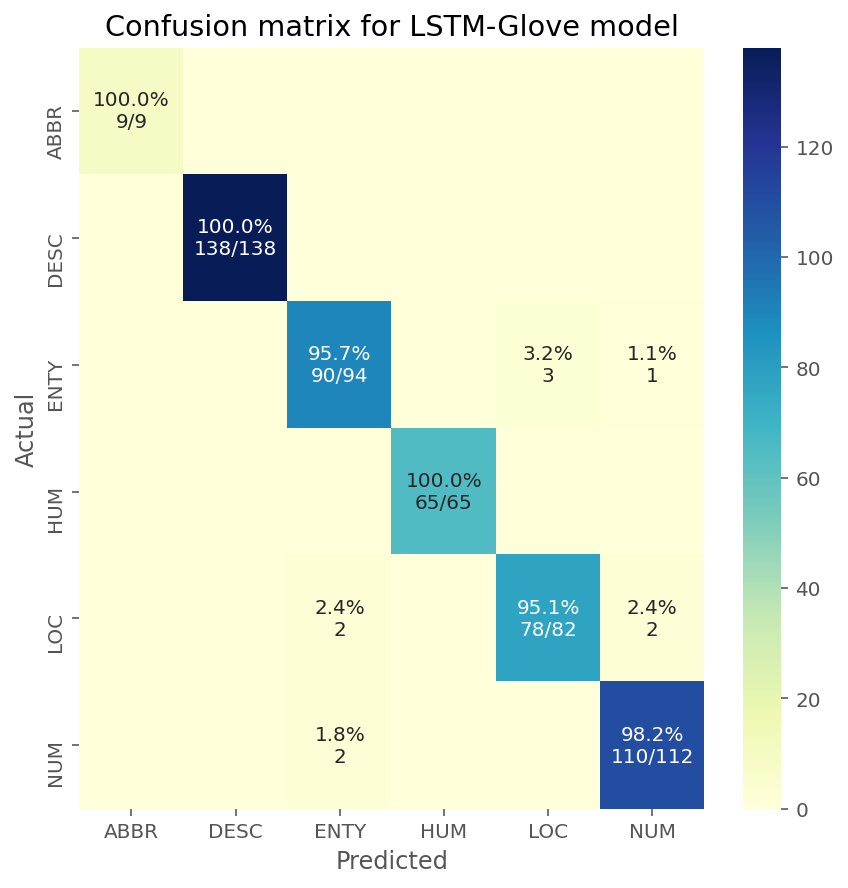

In [91]:
# decode the label encoded results
test_pred_decode = encoder.inverse_transform(y_pred_lstm)
# Showing Confusion Matrix for LSTM model
plot_cm(test_pred_decode, df_test.category, 'Confusion matrix for LSTM-Glove model', figsize=(7,7))

In [92]:
# Save results
data = {'model': 'GloVe + LSTM', 'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}
df_performance = df_performance.append(data, ignore_index=True)

# BERT

In [93]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(6, activation='softmax')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model, clf_output

In [94]:
# load it from local drive
import shutil
shutil.unpack_archive("bert_en_uncased_L-24_H-1024_A-16_1.tar.gz", "./bert_en_uncased_L-24_H-1024_A-16_1/")
model_path = "bert_en_uncased_L-24_H-1024_A-16_1"
# Download BERT layer from tfhub
# model_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(model_path, trainable=True)

In [95]:
train = df_train
test = df_test

In [96]:
# Google tokenizer download
# !wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

#load tokenizer, vocab, the tokenization is the file named as tokenization.py 
#the Tokenization.py file
import tokenization
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [97]:
#prepare the training data and encode data into tokens, masks and segment flags
train_input = bert_encode(train.question.values, tokenizer, max_len=35)
test_input = bert_encode(test.question.values, tokenizer, max_len=35)
train_labels = train.category_en.values

In [98]:
# Build the model
model,clf_output = build_model(bert_layer, max_len=35)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 35)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 35)]         0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [99]:
#train the model
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

history_bert = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=5,
    callbacks=[checkpoint],
    batch_size=16
)

Epoch 1/5
273/273 [==============================] - 201s 736ms/step - loss: 0.1497 - accuracy: 0.9557 - val_loss: 0.0594 - val_accuracy: 0.9835
Epoch 2/5
273/273 [==============================] - 198s 726ms/step - loss: 0.0146 - accuracy: 0.9963 - val_loss: 0.0256 - val_accuracy: 0.9954
Epoch 3/5
273/273 [==============================] - 123s 451ms/step - loss: 0.0064 - accuracy: 0.9982 - val_loss: 0.0349 - val_accuracy: 0.9908
Epoch 4/5
273/273 [==============================] - 197s 723ms/step - loss: 0.0015 - accuracy: 0.9993 - val_loss: 0.0216 - val_accuracy: 0.9963
Epoch 5/5
273/273 [==============================] - 123s 450ms/step - loss: 1.1980e-04 - accuracy: 1.0000 - val_loss: 0.0219 - val_accuracy: 0.9963


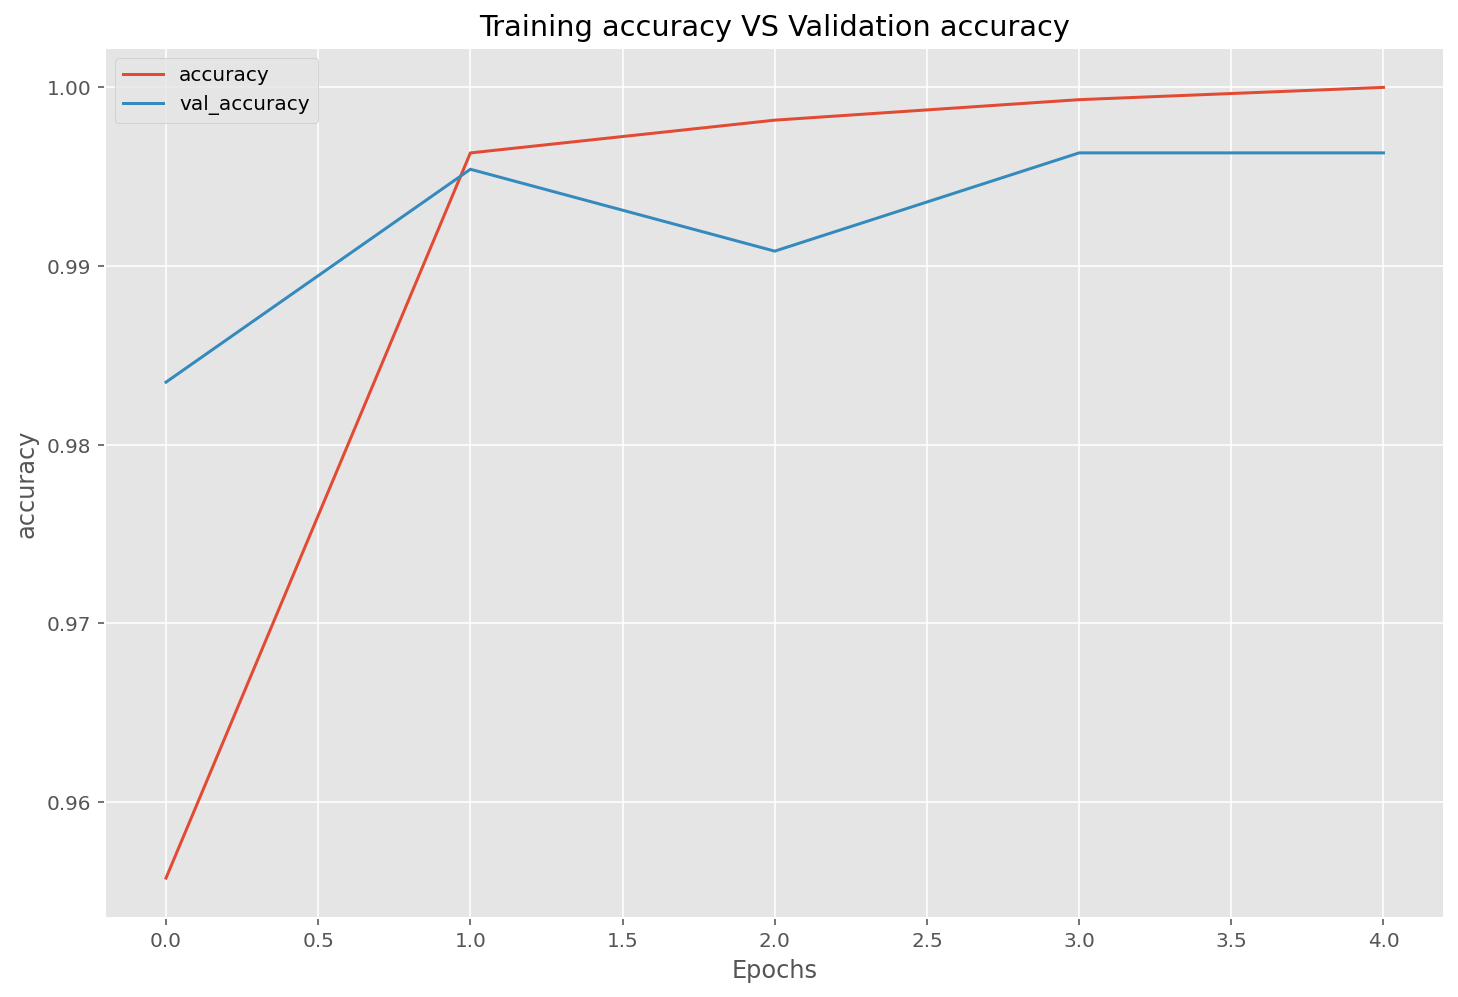

In [100]:
f1 = plt.figure()
plot_graphs(f1,history_bert, "accuracy")

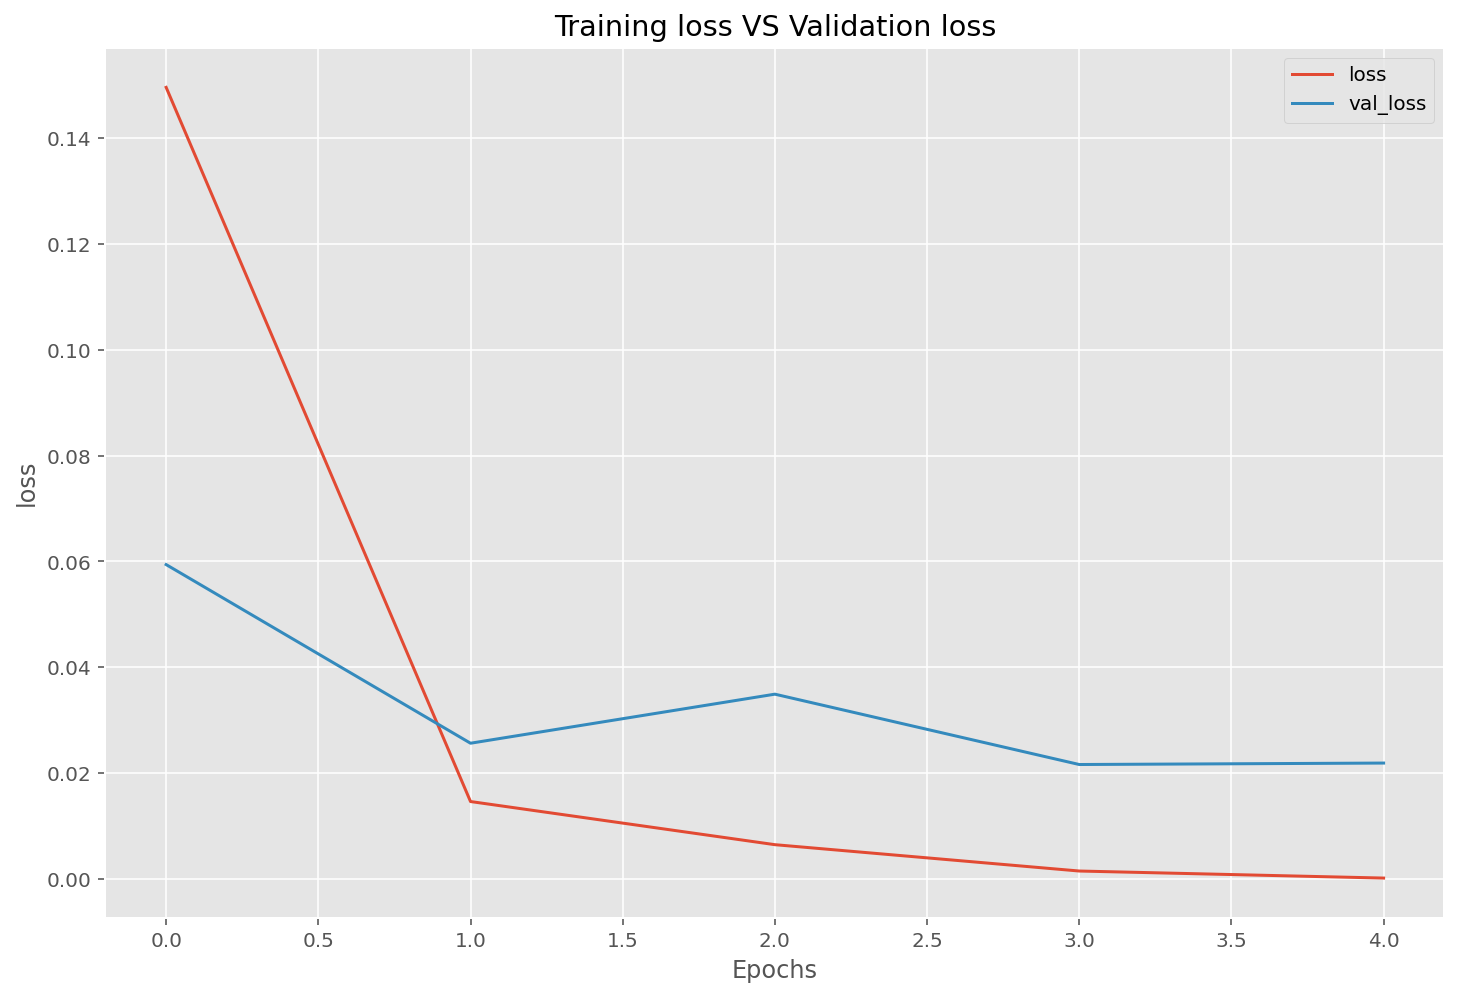

In [101]:
f2 = plt.figure()
plot_graphs(f2,history_bert, "loss")

In [102]:
#prediction of test data 
# Uncomment if loading the saved model
# model.load_weights('model.h5')
y_pred = model.predict(test_input).argmax(axis=-1)

In [103]:
#model evaluation
accuracy, precision, recall, f1 = get_metrics(test.category_en,y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.994 
precision = 0.994 
recall = 0.994 
f1 = 0.994


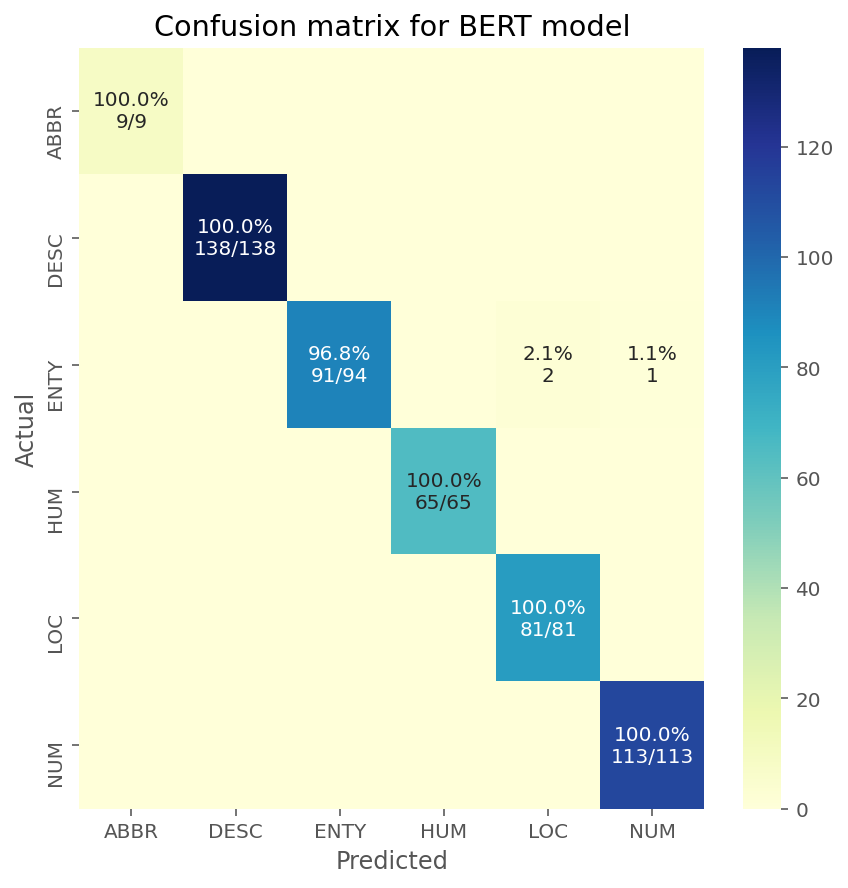

In [104]:
# decode the label encoded results
test_pred_decode = encoder.inverse_transform(y_pred)
# Showing Confusion Matrix for bert model
plot_cm(df_test.category, test_pred_decode, 'Confusion matrix for BERT model', figsize=(7,7))

In [105]:
# Save results
data = {'model': 'BERT', 'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}
df_performance = df_performance.append(data, ignore_index=True)

# Performance Analysis

In [106]:
df_performance

,model,precision,recall,f1,accuracy
0,Tf-Idf + SVM,0.939865,0.934,0.934690,0.934
1,Doc2Vec + Logistic Regression,0.942700,0.942,0.942000,0.942
2,GloVe + LSTM,0.980062,0.980,0.980021,0.980
3,BERT,0.994114,0.994,0.993980,0.994
